In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [4]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████████████| 1513/1513 [00:07<00:00, 199.27GRB/s]


In [5]:
features.shape

(1513, 48000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


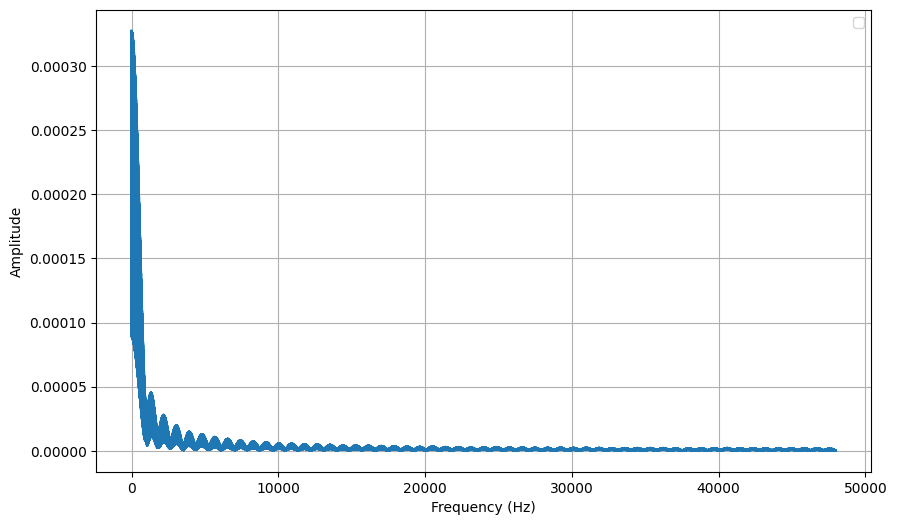

In [6]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0])  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.legend()
plt.grid(True)

In [7]:
features = features[:,:8000]
features.shape

(1513, 8000)

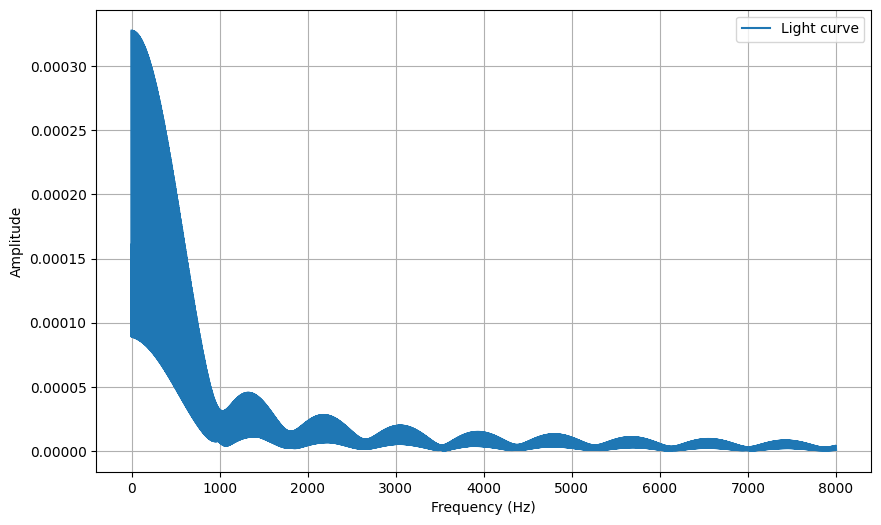

In [8]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0], label='Light curve')  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

In [9]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1513, 8000)
[1.13686838e-16 2.84217094e-17 5.68434189e-17 ... 0.00000000e+00
 0.00000000e+00 5.68434189e-17]
[1. 1. 1. ... 1. 1. 1.]


In [10]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [11]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

In [12]:

# Split the cleaned data into training and testing sets
X_train, X_test, class_train, class_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=205)


training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 64

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [13]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 2
HIDDEN_SIZE_1     = 200

In [14]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        x      = self.fc2(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [15]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [16]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg test loss: {test_loss:>8f} \n")

    return test_loss

In [17]:
features.shape

(1513, 8000)

In [18]:
from tqdm import tqdm

EPOCHS = 200
LEARNING_RATE = 1e-3


# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


train_loss = []
test_loss  = []
for t in tqdm(range(EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------
train loss: 0.999965  [    0/ 1210]


  0%|▏                                          | 1/200 [00:00<02:09,  1.54it/s]

 Avg test loss: 0.792473 

Epoch 2
-------------------------------
train loss: 0.809659  [    0/ 1210]


  1%|▍                                          | 2/200 [00:01<02:05,  1.58it/s]

 Avg test loss: 0.487400 

Epoch 3
-------------------------------
train loss: 0.504352  [    0/ 1210]


  2%|▋                                          | 3/200 [00:02<02:25,  1.35it/s]

 Avg test loss: 0.334243 

Epoch 4
-------------------------------
train loss: 0.337836  [    0/ 1210]


  2%|▊                                          | 4/200 [00:02<02:12,  1.48it/s]

 Avg test loss: 0.259808 

Epoch 5
-------------------------------
train loss: 0.239462  [    0/ 1210]


  2%|█                                          | 5/200 [00:03<02:02,  1.59it/s]

 Avg test loss: 0.206927 

Epoch 6
-------------------------------
train loss: 0.211923  [    0/ 1210]


  3%|█▎                                         | 6/200 [00:03<01:53,  1.72it/s]

 Avg test loss: 0.179429 

Epoch 7
-------------------------------
train loss: 0.182779  [    0/ 1210]


  4%|█▌                                         | 7/200 [00:04<01:49,  1.76it/s]

 Avg test loss: 0.158495 

Epoch 8
-------------------------------
train loss: 0.164562  [    0/ 1210]


  4%|█▋                                         | 8/200 [00:04<01:45,  1.82it/s]

 Avg test loss: 0.139623 

Epoch 9
-------------------------------
train loss: 0.137190  [    0/ 1210]


  4%|█▉                                         | 9/200 [00:05<01:41,  1.88it/s]

 Avg test loss: 0.124278 

Epoch 10
-------------------------------
train loss: 0.126088  [    0/ 1210]


  5%|██                                        | 10/200 [00:05<01:37,  1.94it/s]

 Avg test loss: 0.113290 

Epoch 11
-------------------------------
train loss: 0.121517  [    0/ 1210]


  6%|██▎                                       | 11/200 [00:06<01:36,  1.95it/s]

 Avg test loss: 0.105819 

Epoch 12
-------------------------------
train loss: 0.101094  [    0/ 1210]


  6%|██▌                                       | 12/200 [00:06<01:33,  2.02it/s]

 Avg test loss: 0.102345 

Epoch 13
-------------------------------
train loss: 0.105574  [    0/ 1210]


  6%|██▋                                       | 13/200 [00:07<01:31,  2.04it/s]

 Avg test loss: 0.097612 

Epoch 14
-------------------------------
train loss: 0.109815  [    0/ 1210]


  7%|██▉                                       | 14/200 [00:07<01:30,  2.06it/s]

 Avg test loss: 0.095131 

Epoch 15
-------------------------------
train loss: 0.091834  [    0/ 1210]


  8%|███▏                                      | 15/200 [00:08<01:29,  2.06it/s]

 Avg test loss: 0.091522 

Epoch 16
-------------------------------
train loss: 0.090902  [    0/ 1210]


  8%|███▎                                      | 16/200 [00:08<01:29,  2.05it/s]

 Avg test loss: 0.090395 

Epoch 17
-------------------------------
train loss: 0.096819  [    0/ 1210]


  8%|███▌                                      | 17/200 [00:09<01:28,  2.07it/s]

 Avg test loss: 0.087553 

Epoch 18
-------------------------------
train loss: 0.095470  [    0/ 1210]


  9%|███▊                                      | 18/200 [00:09<01:27,  2.07it/s]

 Avg test loss: 0.087020 

Epoch 19
-------------------------------
train loss: 0.088128  [    0/ 1210]


 10%|███▉                                      | 19/200 [00:10<01:28,  2.06it/s]

 Avg test loss: 0.085731 

Epoch 20
-------------------------------
train loss: 0.093212  [    0/ 1210]


 10%|████▏                                     | 20/200 [00:10<01:30,  1.98it/s]

 Avg test loss: 0.085466 

Epoch 21
-------------------------------
train loss: 0.093056  [    0/ 1210]


 10%|████▍                                     | 21/200 [00:11<01:29,  2.00it/s]

 Avg test loss: 0.084135 

Epoch 22
-------------------------------
train loss: 0.098930  [    0/ 1210]


 11%|████▌                                     | 22/200 [00:11<01:27,  2.03it/s]

 Avg test loss: 0.083782 

Epoch 23
-------------------------------
train loss: 0.078439  [    0/ 1210]


 12%|████▊                                     | 23/200 [00:12<01:31,  1.94it/s]

 Avg test loss: 0.083616 

Epoch 24
-------------------------------
train loss: 0.079339  [    0/ 1210]


 12%|█████                                     | 24/200 [00:12<01:30,  1.95it/s]

 Avg test loss: 0.082398 

Epoch 25
-------------------------------
train loss: 0.084552  [    0/ 1210]


 12%|█████▎                                    | 25/200 [00:13<01:28,  1.98it/s]

 Avg test loss: 0.081266 

Epoch 26
-------------------------------
train loss: 0.090150  [    0/ 1210]


 13%|█████▍                                    | 26/200 [00:13<01:25,  2.03it/s]

 Avg test loss: 0.082791 

Epoch 27
-------------------------------
train loss: 0.083148  [    0/ 1210]


 14%|█████▋                                    | 27/200 [00:14<01:24,  2.04it/s]

 Avg test loss: 0.081607 

Epoch 28
-------------------------------
train loss: 0.078786  [    0/ 1210]


 14%|█████▉                                    | 28/200 [00:14<01:23,  2.06it/s]

 Avg test loss: 0.081161 

Epoch 29
-------------------------------
train loss: 0.087804  [    0/ 1210]


 14%|██████                                    | 29/200 [00:15<01:22,  2.07it/s]

 Avg test loss: 0.080984 

Epoch 30
-------------------------------
train loss: 0.084702  [    0/ 1210]


 15%|██████▎                                   | 30/200 [00:15<01:21,  2.10it/s]

 Avg test loss: 0.081500 

Epoch 31
-------------------------------
train loss: 0.088052  [    0/ 1210]


 16%|██████▌                                   | 31/200 [00:16<01:20,  2.09it/s]

 Avg test loss: 0.079865 

Epoch 32
-------------------------------
train loss: 0.077234  [    0/ 1210]


 16%|██████▋                                   | 32/200 [00:16<01:22,  2.03it/s]

 Avg test loss: 0.078841 

Epoch 33
-------------------------------
train loss: 0.078459  [    0/ 1210]


 16%|██████▉                                   | 33/200 [00:17<01:37,  1.72it/s]

 Avg test loss: 0.079593 

Epoch 34
-------------------------------
train loss: 0.080911  [    0/ 1210]


 17%|███████▏                                  | 34/200 [00:17<01:36,  1.73it/s]

 Avg test loss: 0.079142 

Epoch 35
-------------------------------
train loss: 0.078385  [    0/ 1210]


 18%|███████▎                                  | 35/200 [00:18<01:34,  1.74it/s]

 Avg test loss: 0.078410 

Epoch 36
-------------------------------
train loss: 0.075268  [    0/ 1210]


 18%|███████▌                                  | 36/200 [00:19<01:58,  1.39it/s]

 Avg test loss: 0.078319 

Epoch 37
-------------------------------
train loss: 0.079486  [    0/ 1210]


 18%|███████▊                                  | 37/200 [00:20<01:50,  1.48it/s]

 Avg test loss: 0.078468 

Epoch 38
-------------------------------
train loss: 0.078014  [    0/ 1210]


 19%|███████▉                                  | 38/200 [00:20<01:42,  1.58it/s]

 Avg test loss: 0.078735 

Epoch 39
-------------------------------
train loss: 0.072577  [    0/ 1210]


 20%|████████▏                                 | 39/200 [00:21<01:34,  1.71it/s]

 Avg test loss: 0.077089 

Epoch 40
-------------------------------
train loss: 0.088883  [    0/ 1210]


 20%|████████▍                                 | 40/200 [00:21<01:38,  1.63it/s]

 Avg test loss: 0.078018 

Epoch 41
-------------------------------
train loss: 0.073453  [    0/ 1210]


 20%|████████▌                                 | 41/200 [00:22<01:35,  1.67it/s]

 Avg test loss: 0.077070 

Epoch 42
-------------------------------
train loss: 0.069930  [    0/ 1210]


 21%|████████▊                                 | 42/200 [00:23<01:43,  1.53it/s]

 Avg test loss: 0.076949 

Epoch 43
-------------------------------
train loss: 0.073137  [    0/ 1210]


 22%|█████████                                 | 43/200 [00:23<01:37,  1.61it/s]

 Avg test loss: 0.077103 

Epoch 44
-------------------------------
train loss: 0.081700  [    0/ 1210]


 22%|█████████▏                                | 44/200 [00:24<01:29,  1.74it/s]

 Avg test loss: 0.076966 

Epoch 45
-------------------------------
train loss: 0.073135  [    0/ 1210]


 22%|█████████▍                                | 45/200 [00:24<01:27,  1.78it/s]

 Avg test loss: 0.077006 

Epoch 46
-------------------------------
train loss: 0.086894  [    0/ 1210]


 23%|█████████▋                                | 46/200 [00:25<01:21,  1.88it/s]

 Avg test loss: 0.077202 

Epoch 47
-------------------------------
train loss: 0.066817  [    0/ 1210]


 24%|█████████▊                                | 47/200 [00:25<01:21,  1.87it/s]

 Avg test loss: 0.076934 

Epoch 48
-------------------------------
train loss: 0.075551  [    0/ 1210]


 24%|██████████                                | 48/200 [00:26<01:27,  1.73it/s]

 Avg test loss: 0.076470 

Epoch 49
-------------------------------
train loss: 0.080287  [    0/ 1210]


 24%|██████████▎                               | 49/200 [00:26<01:24,  1.79it/s]

 Avg test loss: 0.076328 

Epoch 50
-------------------------------
train loss: 0.072023  [    0/ 1210]


 25%|██████████▌                               | 50/200 [00:27<01:27,  1.71it/s]

 Avg test loss: 0.076798 

Epoch 51
-------------------------------
train loss: 0.076076  [    0/ 1210]


 26%|██████████▋                               | 51/200 [00:28<01:24,  1.76it/s]

 Avg test loss: 0.076069 

Epoch 52
-------------------------------
train loss: 0.074707  [    0/ 1210]


 26%|██████████▉                               | 52/200 [00:28<01:26,  1.71it/s]

 Avg test loss: 0.076226 

Epoch 53
-------------------------------
train loss: 0.072671  [    0/ 1210]


 26%|███████████▏                              | 53/200 [00:29<01:21,  1.81it/s]

 Avg test loss: 0.076074 

Epoch 54
-------------------------------
train loss: 0.062158  [    0/ 1210]


 27%|███████████▎                              | 54/200 [00:29<01:17,  1.88it/s]

 Avg test loss: 0.076192 

Epoch 55
-------------------------------
train loss: 0.068200  [    0/ 1210]


 28%|███████████▌                              | 55/200 [00:30<01:19,  1.83it/s]

 Avg test loss: 0.076385 

Epoch 56
-------------------------------
train loss: 0.067149  [    0/ 1210]


 28%|███████████▊                              | 56/200 [00:30<01:15,  1.91it/s]

 Avg test loss: 0.075818 

Epoch 57
-------------------------------
train loss: 0.074286  [    0/ 1210]


 28%|███████████▉                              | 57/200 [00:31<01:16,  1.87it/s]

 Avg test loss: 0.075363 

Epoch 58
-------------------------------
train loss: 0.083887  [    0/ 1210]


 29%|████████████▏                             | 58/200 [00:32<01:26,  1.65it/s]

 Avg test loss: 0.077169 

Epoch 59
-------------------------------
train loss: 0.079710  [    0/ 1210]


 30%|████████████▍                             | 59/200 [00:32<01:24,  1.68it/s]

 Avg test loss: 0.076226 

Epoch 60
-------------------------------
train loss: 0.080682  [    0/ 1210]


 30%|████████████▌                             | 60/200 [00:33<01:18,  1.79it/s]

 Avg test loss: 0.076026 

Epoch 61
-------------------------------
train loss: 0.070425  [    0/ 1210]


 30%|████████████▊                             | 61/200 [00:33<01:22,  1.69it/s]

 Avg test loss: 0.076118 

Epoch 62
-------------------------------
train loss: 0.073493  [    0/ 1210]


 31%|█████████████                             | 62/200 [00:34<01:16,  1.79it/s]

 Avg test loss: 0.075510 

Epoch 63
-------------------------------
train loss: 0.076726  [    0/ 1210]


 32%|█████████████▏                            | 63/200 [00:34<01:17,  1.76it/s]

 Avg test loss: 0.077740 

Epoch 64
-------------------------------
train loss: 0.074340  [    0/ 1210]


 32%|█████████████▍                            | 64/200 [00:35<01:17,  1.76it/s]

 Avg test loss: 0.075647 

Epoch 65
-------------------------------
train loss: 0.064830  [    0/ 1210]


 32%|█████████████▋                            | 65/200 [00:35<01:14,  1.82it/s]

 Avg test loss: 0.075859 

Epoch 66
-------------------------------
train loss: 0.068885  [    0/ 1210]


 33%|█████████████▊                            | 66/200 [00:36<01:10,  1.90it/s]

 Avg test loss: 0.075511 

Epoch 67
-------------------------------
train loss: 0.083608  [    0/ 1210]


 34%|██████████████                            | 67/200 [00:36<01:08,  1.94it/s]

 Avg test loss: 0.076442 

Epoch 68
-------------------------------
train loss: 0.068102  [    0/ 1210]


 34%|██████████████▎                           | 68/200 [00:37<01:06,  1.99it/s]

 Avg test loss: 0.075080 

Epoch 69
-------------------------------
train loss: 0.072056  [    0/ 1210]


 34%|██████████████▍                           | 69/200 [00:37<01:05,  1.99it/s]

 Avg test loss: 0.075680 

Epoch 70
-------------------------------
train loss: 0.073018  [    0/ 1210]


 35%|██████████████▋                           | 70/200 [00:38<01:04,  2.01it/s]

 Avg test loss: 0.076117 

Epoch 71
-------------------------------
train loss: 0.079718  [    0/ 1210]


 36%|██████████████▉                           | 71/200 [00:38<01:03,  2.04it/s]

 Avg test loss: 0.075872 

Epoch 72
-------------------------------
train loss: 0.074914  [    0/ 1210]


 36%|███████████████                           | 72/200 [00:39<01:01,  2.06it/s]

 Avg test loss: 0.075798 

Epoch 73
-------------------------------
train loss: 0.072984  [    0/ 1210]


 36%|███████████████▎                          | 73/200 [00:39<01:01,  2.07it/s]

 Avg test loss: 0.076265 

Epoch 74
-------------------------------
train loss: 0.069164  [    0/ 1210]


 37%|███████████████▌                          | 74/200 [00:40<01:00,  2.08it/s]

 Avg test loss: 0.075729 

Epoch 75
-------------------------------
train loss: 0.077317  [    0/ 1210]


 38%|███████████████▊                          | 75/200 [00:40<01:00,  2.08it/s]

 Avg test loss: 0.074896 

Epoch 76
-------------------------------
train loss: 0.077858  [    0/ 1210]


 38%|███████████████▉                          | 76/200 [00:41<00:58,  2.11it/s]

 Avg test loss: 0.074669 

Epoch 77
-------------------------------
train loss: 0.077242  [    0/ 1210]


 38%|████████████████▏                         | 77/200 [00:41<00:58,  2.09it/s]

 Avg test loss: 0.075461 

Epoch 78
-------------------------------
train loss: 0.066844  [    0/ 1210]


 39%|████████████████▍                         | 78/200 [00:42<00:57,  2.11it/s]

 Avg test loss: 0.075591 

Epoch 79
-------------------------------
train loss: 0.076266  [    0/ 1210]


 40%|████████████████▌                         | 79/200 [00:42<00:59,  2.02it/s]

 Avg test loss: 0.075094 

Epoch 80
-------------------------------
train loss: 0.056620  [    0/ 1210]


 40%|████████████████▊                         | 80/200 [00:43<00:58,  2.06it/s]

 Avg test loss: 0.075709 

Epoch 81
-------------------------------
train loss: 0.062844  [    0/ 1210]


 40%|█████████████████                         | 81/200 [00:43<00:57,  2.07it/s]

 Avg test loss: 0.075887 

Epoch 82
-------------------------------
train loss: 0.076208  [    0/ 1210]


 41%|█████████████████▏                        | 82/200 [00:44<00:56,  2.09it/s]

 Avg test loss: 0.074747 

Epoch 83
-------------------------------
train loss: 0.075296  [    0/ 1210]


 42%|█████████████████▍                        | 83/200 [00:44<00:55,  2.10it/s]

 Avg test loss: 0.075380 

Epoch 84
-------------------------------
train loss: 0.070500  [    0/ 1210]


 42%|█████████████████▋                        | 84/200 [00:44<00:54,  2.11it/s]

 Avg test loss: 0.075268 

Epoch 85
-------------------------------
train loss: 0.075072  [    0/ 1210]


 42%|█████████████████▊                        | 85/200 [00:45<00:54,  2.10it/s]

 Avg test loss: 0.074857 

Epoch 86
-------------------------------
train loss: 0.073317  [    0/ 1210]


 43%|██████████████████                        | 86/200 [00:45<00:53,  2.13it/s]

 Avg test loss: 0.075045 

Epoch 87
-------------------------------
train loss: 0.072155  [    0/ 1210]


 44%|██████████████████▎                       | 87/200 [00:46<00:53,  2.11it/s]

 Avg test loss: 0.075644 

Epoch 88
-------------------------------
train loss: 0.068959  [    0/ 1210]


 44%|██████████████████▍                       | 88/200 [00:46<00:53,  2.11it/s]

 Avg test loss: 0.076111 

Epoch 89
-------------------------------
train loss: 0.075752  [    0/ 1210]


 44%|██████████████████▋                       | 89/200 [00:47<00:53,  2.08it/s]

 Avg test loss: 0.076108 

Epoch 90
-------------------------------
train loss: 0.071039  [    0/ 1210]


 45%|██████████████████▉                       | 90/200 [00:47<00:54,  2.00it/s]

 Avg test loss: 0.076220 

Epoch 91
-------------------------------
train loss: 0.071677  [    0/ 1210]


 46%|███████████████████                       | 91/200 [00:48<01:02,  1.75it/s]

 Avg test loss: 0.075925 

Epoch 92
-------------------------------
train loss: 0.078685  [    0/ 1210]


 46%|███████████████████▎                      | 92/200 [00:49<01:00,  1.78it/s]

 Avg test loss: 0.075757 

Epoch 93
-------------------------------
train loss: 0.068623  [    0/ 1210]


 46%|███████████████████▌                      | 93/200 [00:49<00:59,  1.81it/s]

 Avg test loss: 0.075427 

Epoch 94
-------------------------------
train loss: 0.074791  [    0/ 1210]


 47%|███████████████████▋                      | 94/200 [00:50<00:57,  1.85it/s]

 Avg test loss: 0.075132 

Epoch 95
-------------------------------
train loss: 0.071076  [    0/ 1210]


 48%|███████████████████▉                      | 95/200 [00:50<00:59,  1.78it/s]

 Avg test loss: 0.074093 

Epoch 96
-------------------------------
train loss: 0.071737  [    0/ 1210]


 48%|████████████████████▏                     | 96/200 [00:51<00:58,  1.78it/s]

 Avg test loss: 0.075085 

Epoch 97
-------------------------------
train loss: 0.066140  [    0/ 1210]


 48%|████████████████████▎                     | 97/200 [00:51<00:56,  1.81it/s]

 Avg test loss: 0.076466 

Epoch 98
-------------------------------
train loss: 0.068016  [    0/ 1210]


 49%|████████████████████▌                     | 98/200 [00:52<00:55,  1.85it/s]

 Avg test loss: 0.075460 

Epoch 99
-------------------------------
train loss: 0.070366  [    0/ 1210]


 50%|████████████████████▊                     | 99/200 [00:53<00:56,  1.78it/s]

 Avg test loss: 0.075394 

Epoch 100
-------------------------------
train loss: 0.075930  [    0/ 1210]


 50%|████████████████████▌                    | 100/200 [00:53<00:54,  1.82it/s]

 Avg test loss: 0.076658 

Epoch 101
-------------------------------
train loss: 0.074690  [    0/ 1210]


 50%|████████████████████▋                    | 101/200 [00:54<00:53,  1.84it/s]

 Avg test loss: 0.076804 

Epoch 102
-------------------------------
train loss: 0.066379  [    0/ 1210]


 51%|████████████████████▉                    | 102/200 [00:54<00:52,  1.88it/s]

 Avg test loss: 0.075823 

Epoch 103
-------------------------------
train loss: 0.077252  [    0/ 1210]


 52%|█████████████████████                    | 103/200 [00:55<00:54,  1.79it/s]

 Avg test loss: 0.075031 

Epoch 104
-------------------------------
train loss: 0.071871  [    0/ 1210]


 52%|█████████████████████▎                   | 104/200 [00:55<00:56,  1.69it/s]

 Avg test loss: 0.075707 

Epoch 105
-------------------------------
train loss: 0.076437  [    0/ 1210]


 52%|█████████████████████▌                   | 105/200 [00:56<00:53,  1.78it/s]

 Avg test loss: 0.075051 

Epoch 106
-------------------------------
train loss: 0.075858  [    0/ 1210]


 53%|█████████████████████▋                   | 106/200 [00:56<00:50,  1.86it/s]

 Avg test loss: 0.074179 

Epoch 107
-------------------------------
train loss: 0.071993  [    0/ 1210]


 54%|█████████████████████▉                   | 107/200 [00:57<00:48,  1.91it/s]

 Avg test loss: 0.075852 

Epoch 108
-------------------------------
train loss: 0.076011  [    0/ 1210]


 54%|██████████████████████▏                  | 108/200 [00:57<00:48,  1.89it/s]

 Avg test loss: 0.074986 

Epoch 109
-------------------------------
train loss: 0.075386  [    0/ 1210]


 55%|██████████████████████▎                  | 109/200 [00:58<00:49,  1.84it/s]

 Avg test loss: 0.074569 

Epoch 110
-------------------------------
train loss: 0.073461  [    0/ 1210]


 55%|██████████████████████▌                  | 110/200 [00:59<00:49,  1.83it/s]

 Avg test loss: 0.074792 

Epoch 111
-------------------------------
train loss: 0.065513  [    0/ 1210]


 56%|██████████████████████▊                  | 111/200 [00:59<00:48,  1.83it/s]

 Avg test loss: 0.074647 

Epoch 112
-------------------------------
train loss: 0.070530  [    0/ 1210]


 56%|██████████████████████▉                  | 112/200 [01:00<00:59,  1.47it/s]

 Avg test loss: 0.076237 

Epoch 113
-------------------------------
train loss: 0.068909  [    0/ 1210]


 56%|███████████████████████▏                 | 113/200 [01:01<01:08,  1.27it/s]

 Avg test loss: 0.075121 

Epoch 114
-------------------------------
train loss: 0.079299  [    0/ 1210]


 57%|███████████████████████▎                 | 114/200 [01:03<01:39,  1.16s/it]

 Avg test loss: 0.075090 

Epoch 115
-------------------------------
train loss: 0.071425  [    0/ 1210]


 57%|███████████████████████▌                 | 115/200 [01:05<01:46,  1.26s/it]

 Avg test loss: 0.074972 

Epoch 116
-------------------------------
train loss: 0.068175  [    0/ 1210]


 58%|███████████████████████▊                 | 116/200 [01:06<01:53,  1.35s/it]

 Avg test loss: 0.075363 

Epoch 117
-------------------------------
train loss: 0.075812  [    0/ 1210]


 58%|███████████████████████▉                 | 117/200 [01:07<01:35,  1.15s/it]

 Avg test loss: 0.073652 

Epoch 118
-------------------------------
train loss: 0.070410  [    0/ 1210]


 59%|████████████████████████▏                | 118/200 [01:07<01:20,  1.01it/s]

 Avg test loss: 0.074754 

Epoch 119
-------------------------------
train loss: 0.070647  [    0/ 1210]


 60%|████████████████████████▍                | 119/200 [01:08<01:11,  1.14it/s]

 Avg test loss: 0.075000 

Epoch 120
-------------------------------
train loss: 0.075291  [    0/ 1210]


 60%|████████████████████████▌                | 120/200 [01:09<01:02,  1.28it/s]

 Avg test loss: 0.074923 

Epoch 121
-------------------------------
train loss: 0.066606  [    0/ 1210]


 60%|████████████████████████▊                | 121/200 [01:09<00:57,  1.38it/s]

 Avg test loss: 0.075215 

Epoch 122
-------------------------------
train loss: 0.067067  [    0/ 1210]


 61%|█████████████████████████                | 122/200 [01:10<00:51,  1.52it/s]

 Avg test loss: 0.074598 

Epoch 123
-------------------------------
train loss: 0.076722  [    0/ 1210]


 62%|█████████████████████████▏               | 123/200 [01:10<00:50,  1.54it/s]

 Avg test loss: 0.075099 

Epoch 124
-------------------------------
train loss: 0.063770  [    0/ 1210]


 62%|█████████████████████████▍               | 124/200 [01:11<00:47,  1.60it/s]

 Avg test loss: 0.074132 

Epoch 125
-------------------------------
train loss: 0.069735  [    0/ 1210]


 62%|█████████████████████████▋               | 125/200 [01:12<00:45,  1.63it/s]

 Avg test loss: 0.075041 

Epoch 126
-------------------------------
train loss: 0.072901  [    0/ 1210]


 63%|█████████████████████████▊               | 126/200 [01:12<00:43,  1.71it/s]

 Avg test loss: 0.073957 

Epoch 127
-------------------------------
train loss: 0.081123  [    0/ 1210]


 64%|██████████████████████████               | 127/200 [01:13<00:47,  1.53it/s]

 Avg test loss: 0.074239 

Epoch 128
-------------------------------
train loss: 0.070906  [    0/ 1210]


 64%|██████████████████████████▏              | 128/200 [01:13<00:44,  1.61it/s]

 Avg test loss: 0.075848 

Epoch 129
-------------------------------
train loss: 0.065762  [    0/ 1210]


 64%|██████████████████████████▍              | 129/200 [01:14<00:41,  1.70it/s]

 Avg test loss: 0.073505 

Epoch 130
-------------------------------
train loss: 0.072544  [    0/ 1210]


 65%|██████████████████████████▋              | 130/200 [01:14<00:39,  1.78it/s]

 Avg test loss: 0.074666 

Epoch 131
-------------------------------
train loss: 0.065015  [    0/ 1210]


 66%|██████████████████████████▊              | 131/200 [01:15<00:37,  1.83it/s]

 Avg test loss: 0.074726 

Epoch 132
-------------------------------
train loss: 0.080810  [    0/ 1210]


 66%|███████████████████████████              | 132/200 [01:16<00:41,  1.65it/s]

 Avg test loss: 0.074931 

Epoch 133
-------------------------------
train loss: 0.066041  [    0/ 1210]


 66%|███████████████████████████▎             | 133/200 [01:16<00:40,  1.67it/s]

 Avg test loss: 0.073938 

Epoch 134
-------------------------------
train loss: 0.066520  [    0/ 1210]


 67%|███████████████████████████▍             | 134/200 [01:17<00:39,  1.67it/s]

 Avg test loss: 0.075926 

Epoch 135
-------------------------------
train loss: 0.061126  [    0/ 1210]


 68%|███████████████████████████▋             | 135/200 [01:17<00:37,  1.75it/s]

 Avg test loss: 0.074741 

Epoch 136
-------------------------------
train loss: 0.067863  [    0/ 1210]


 68%|███████████████████████████▉             | 136/200 [01:18<00:39,  1.64it/s]

 Avg test loss: 0.075188 

Epoch 137
-------------------------------
train loss: 0.070872  [    0/ 1210]


 68%|████████████████████████████             | 137/200 [01:19<00:37,  1.66it/s]

 Avg test loss: 0.074936 

Epoch 138
-------------------------------
train loss: 0.073765  [    0/ 1210]


 69%|████████████████████████████▎            | 138/200 [01:20<00:41,  1.49it/s]

 Avg test loss: 0.073757 

Epoch 139
-------------------------------
train loss: 0.064893  [    0/ 1210]


 70%|████████████████████████████▍            | 139/200 [01:20<00:42,  1.42it/s]

 Avg test loss: 0.074739 

Epoch 140
-------------------------------
train loss: 0.066173  [    0/ 1210]


 70%|████████████████████████████▋            | 140/200 [01:21<00:40,  1.48it/s]

 Avg test loss: 0.074363 

Epoch 141
-------------------------------
train loss: 0.068149  [    0/ 1210]


 70%|████████████████████████████▉            | 141/200 [01:21<00:37,  1.57it/s]

 Avg test loss: 0.073752 

Epoch 142
-------------------------------
train loss: 0.075307  [    0/ 1210]


 71%|█████████████████████████████            | 142/200 [01:22<00:35,  1.62it/s]

 Avg test loss: 0.073797 

Epoch 143
-------------------------------
train loss: 0.069126  [    0/ 1210]


 72%|█████████████████████████████▎           | 143/200 [01:23<00:34,  1.65it/s]

 Avg test loss: 0.074061 

Epoch 144
-------------------------------
train loss: 0.073280  [    0/ 1210]


 72%|█████████████████████████████▌           | 144/200 [01:23<00:34,  1.63it/s]

 Avg test loss: 0.073793 

Epoch 145
-------------------------------
train loss: 0.067099  [    0/ 1210]


 72%|█████████████████████████████▋           | 145/200 [01:24<00:34,  1.60it/s]

 Avg test loss: 0.074300 

Epoch 146
-------------------------------
train loss: 0.071394  [    0/ 1210]


 73%|█████████████████████████████▉           | 146/200 [01:25<00:37,  1.43it/s]

 Avg test loss: 0.074386 

Epoch 147
-------------------------------
train loss: 0.064425  [    0/ 1210]


 74%|██████████████████████████████▏          | 147/200 [01:25<00:36,  1.45it/s]

 Avg test loss: 0.074460 

Epoch 148
-------------------------------
train loss: 0.060023  [    0/ 1210]


 74%|██████████████████████████████▎          | 148/200 [01:26<00:35,  1.46it/s]

 Avg test loss: 0.074105 

Epoch 149
-------------------------------
train loss: 0.084756  [    0/ 1210]


 74%|██████████████████████████████▌          | 149/200 [01:27<00:32,  1.55it/s]

 Avg test loss: 0.073651 

Epoch 150
-------------------------------
train loss: 0.067493  [    0/ 1210]


 75%|██████████████████████████████▊          | 150/200 [01:28<00:36,  1.36it/s]

 Avg test loss: 0.074415 

Epoch 151
-------------------------------
train loss: 0.071366  [    0/ 1210]


 76%|██████████████████████████████▉          | 151/200 [01:28<00:32,  1.51it/s]

 Avg test loss: 0.074657 

Epoch 152
-------------------------------
train loss: 0.064764  [    0/ 1210]


 76%|███████████████████████████████▏         | 152/200 [01:29<00:29,  1.62it/s]

 Avg test loss: 0.073718 

Epoch 153
-------------------------------
train loss: 0.076040  [    0/ 1210]


 76%|███████████████████████████████▎         | 153/200 [01:29<00:29,  1.58it/s]

 Avg test loss: 0.074987 

Epoch 154
-------------------------------
train loss: 0.070609  [    0/ 1210]


 77%|███████████████████████████████▌         | 154/200 [01:31<00:48,  1.04s/it]

 Avg test loss: 0.074654 

Epoch 155
-------------------------------
train loss: 0.072169  [    0/ 1210]


 78%|███████████████████████████████▊         | 155/200 [01:33<00:53,  1.18s/it]

 Avg test loss: 0.074864 

Epoch 156
-------------------------------
train loss: 0.072203  [    0/ 1210]


 78%|███████████████████████████████▉         | 156/200 [01:34<00:55,  1.26s/it]

 Avg test loss: 0.073512 

Epoch 157
-------------------------------
train loss: 0.063106  [    0/ 1210]


 78%|████████████████████████████████▏        | 157/200 [01:35<00:48,  1.13s/it]

 Avg test loss: 0.074178 

Epoch 158
-------------------------------
train loss: 0.074368  [    0/ 1210]


 79%|████████████████████████████████▍        | 158/200 [01:36<00:40,  1.03it/s]

 Avg test loss: 0.075170 

Epoch 159
-------------------------------
train loss: 0.068925  [    0/ 1210]


 80%|████████████████████████████████▌        | 159/200 [01:36<00:34,  1.19it/s]

 Avg test loss: 0.074148 

Epoch 160
-------------------------------
train loss: 0.062486  [    0/ 1210]


 80%|████████████████████████████████▊        | 160/200 [01:37<00:29,  1.34it/s]

 Avg test loss: 0.074141 

Epoch 161
-------------------------------
train loss: 0.072023  [    0/ 1210]


 80%|█████████████████████████████████        | 161/200 [01:37<00:27,  1.41it/s]

 Avg test loss: 0.073712 

Epoch 162
-------------------------------
train loss: 0.064373  [    0/ 1210]


 81%|█████████████████████████████████▏       | 162/200 [01:38<00:29,  1.28it/s]

 Avg test loss: 0.073496 

Epoch 163
-------------------------------
train loss: 0.065491  [    0/ 1210]


 82%|█████████████████████████████████▍       | 163/200 [01:39<00:27,  1.36it/s]

 Avg test loss: 0.074686 

Epoch 164
-------------------------------
train loss: 0.066491  [    0/ 1210]


 82%|█████████████████████████████████▌       | 164/200 [01:40<00:25,  1.39it/s]

 Avg test loss: 0.074263 

Epoch 165
-------------------------------
train loss: 0.077772  [    0/ 1210]


 82%|█████████████████████████████████▊       | 165/200 [01:40<00:24,  1.43it/s]

 Avg test loss: 0.073773 

Epoch 166
-------------------------------
train loss: 0.072045  [    0/ 1210]


 83%|██████████████████████████████████       | 166/200 [01:41<00:23,  1.48it/s]

 Avg test loss: 0.073773 

Epoch 167
-------------------------------
train loss: 0.065072  [    0/ 1210]


 84%|██████████████████████████████████▏      | 167/200 [01:42<00:24,  1.36it/s]

 Avg test loss: 0.073350 

Epoch 168
-------------------------------
train loss: 0.069179  [    0/ 1210]


 84%|██████████████████████████████████▍      | 168/200 [01:42<00:23,  1.35it/s]

 Avg test loss: 0.073363 

Epoch 169
-------------------------------
train loss: 0.067636  [    0/ 1210]


 84%|██████████████████████████████████▋      | 169/200 [01:43<00:22,  1.37it/s]

 Avg test loss: 0.073908 

Epoch 170
-------------------------------
train loss: 0.071300  [    0/ 1210]


 85%|██████████████████████████████████▊      | 170/200 [01:44<00:22,  1.33it/s]

 Avg test loss: 0.073387 

Epoch 171
-------------------------------
train loss: 0.070100  [    0/ 1210]


 86%|███████████████████████████████████      | 171/200 [01:45<00:20,  1.41it/s]

 Avg test loss: 0.073808 

Epoch 172
-------------------------------
train loss: 0.078093  [    0/ 1210]


 86%|███████████████████████████████████▎     | 172/200 [01:45<00:19,  1.47it/s]

 Avg test loss: 0.074505 

Epoch 173
-------------------------------
train loss: 0.063885  [    0/ 1210]


 86%|███████████████████████████████████▍     | 173/200 [01:46<00:17,  1.56it/s]

 Avg test loss: 0.073779 

Epoch 174
-------------------------------
train loss: 0.066509  [    0/ 1210]


 87%|███████████████████████████████████▋     | 174/200 [01:46<00:15,  1.64it/s]

 Avg test loss: 0.074610 

Epoch 175
-------------------------------
train loss: 0.068889  [    0/ 1210]


 88%|███████████████████████████████████▉     | 175/200 [01:47<00:14,  1.68it/s]

 Avg test loss: 0.074309 

Epoch 176
-------------------------------
train loss: 0.071580  [    0/ 1210]


 88%|████████████████████████████████████     | 176/200 [01:47<00:14,  1.70it/s]

 Avg test loss: 0.073459 

Epoch 177
-------------------------------
train loss: 0.059406  [    0/ 1210]


 88%|████████████████████████████████████▎    | 177/200 [01:48<00:13,  1.72it/s]

 Avg test loss: 0.074247 

Epoch 178
-------------------------------
train loss: 0.075161  [    0/ 1210]


 89%|████████████████████████████████████▍    | 178/200 [01:49<00:13,  1.69it/s]

 Avg test loss: 0.072962 

Epoch 179
-------------------------------
train loss: 0.078128  [    0/ 1210]


 90%|████████████████████████████████████▋    | 179/200 [01:49<00:12,  1.66it/s]

 Avg test loss: 0.073543 

Epoch 180
-------------------------------
train loss: 0.064618  [    0/ 1210]


 90%|████████████████████████████████████▉    | 180/200 [01:50<00:13,  1.46it/s]

 Avg test loss: 0.073507 

Epoch 181
-------------------------------
train loss: 0.070620  [    0/ 1210]


 90%|█████████████████████████████████████    | 181/200 [01:51<00:13,  1.39it/s]

 Avg test loss: 0.075523 

Epoch 182
-------------------------------
train loss: 0.064234  [    0/ 1210]


 91%|█████████████████████████████████████▎   | 182/200 [01:52<00:12,  1.39it/s]

 Avg test loss: 0.074343 

Epoch 183
-------------------------------
train loss: 0.071948  [    0/ 1210]


 92%|█████████████████████████████████████▌   | 183/200 [01:52<00:11,  1.43it/s]

 Avg test loss: 0.073125 

Epoch 184
-------------------------------
train loss: 0.066678  [    0/ 1210]


 92%|█████████████████████████████████████▋   | 184/200 [01:53<00:10,  1.49it/s]

 Avg test loss: 0.073435 

Epoch 185
-------------------------------
train loss: 0.066351  [    0/ 1210]


 92%|█████████████████████████████████████▉   | 185/200 [01:54<00:09,  1.51it/s]

 Avg test loss: 0.073381 

Epoch 186
-------------------------------
train loss: 0.062984  [    0/ 1210]


 93%|██████████████████████████████████████▏  | 186/200 [01:54<00:08,  1.61it/s]

 Avg test loss: 0.073637 

Epoch 187
-------------------------------
train loss: 0.066915  [    0/ 1210]


 94%|██████████████████████████████████████▎  | 187/200 [01:55<00:07,  1.72it/s]

 Avg test loss: 0.072924 

Epoch 188
-------------------------------
train loss: 0.069593  [    0/ 1210]


 94%|██████████████████████████████████████▌  | 188/200 [01:55<00:08,  1.47it/s]

 Avg test loss: 0.073523 

Epoch 189
-------------------------------
train loss: 0.069892  [    0/ 1210]


 94%|██████████████████████████████████████▋  | 189/200 [01:56<00:07,  1.56it/s]

 Avg test loss: 0.074800 

Epoch 190
-------------------------------
train loss: 0.065086  [    0/ 1210]


 95%|██████████████████████████████████████▉  | 190/200 [01:57<00:06,  1.63it/s]

 Avg test loss: 0.073629 

Epoch 191
-------------------------------
train loss: 0.079746  [    0/ 1210]


 96%|███████████████████████████████████████▏ | 191/200 [01:57<00:05,  1.68it/s]

 Avg test loss: 0.073866 

Epoch 192
-------------------------------
train loss: 0.069580  [    0/ 1210]


 96%|███████████████████████████████████████▎ | 192/200 [01:58<00:04,  1.72it/s]

 Avg test loss: 0.074546 

Epoch 193
-------------------------------
train loss: 0.071515  [    0/ 1210]


 96%|███████████████████████████████████████▌ | 193/200 [01:58<00:04,  1.59it/s]

 Avg test loss: 0.074027 

Epoch 194
-------------------------------
train loss: 0.074226  [    0/ 1210]


 97%|███████████████████████████████████████▊ | 194/200 [01:59<00:03,  1.60it/s]

 Avg test loss: 0.073221 

Epoch 195
-------------------------------
train loss: 0.064309  [    0/ 1210]


 98%|███████████████████████████████████████▉ | 195/200 [02:00<00:03,  1.65it/s]

 Avg test loss: 0.074662 

Epoch 196
-------------------------------
train loss: 0.080603  [    0/ 1210]


 98%|████████████████████████████████████████▏| 196/200 [02:00<00:02,  1.64it/s]

 Avg test loss: 0.073333 

Epoch 197
-------------------------------
train loss: 0.063933  [    0/ 1210]


 98%|████████████████████████████████████████▍| 197/200 [02:01<00:01,  1.61it/s]

 Avg test loss: 0.073783 

Epoch 198
-------------------------------
train loss: 0.072573  [    0/ 1210]


 99%|████████████████████████████████████████▌| 198/200 [02:01<00:01,  1.60it/s]

 Avg test loss: 0.073280 

Epoch 199
-------------------------------
train loss: 0.070187  [    0/ 1210]


100%|████████████████████████████████████████▊| 199/200 [02:03<00:00,  1.33it/s]

 Avg test loss: 0.073391 

Epoch 200
-------------------------------
train loss: 0.066869  [    0/ 1210]


100%|█████████████████████████████████████████| 200/200 [02:03<00:00,  1.62it/s]

 Avg test loss: 0.074685 

Done!


In [19]:
plot_train_loss = [x[-1] for x in train_loss]

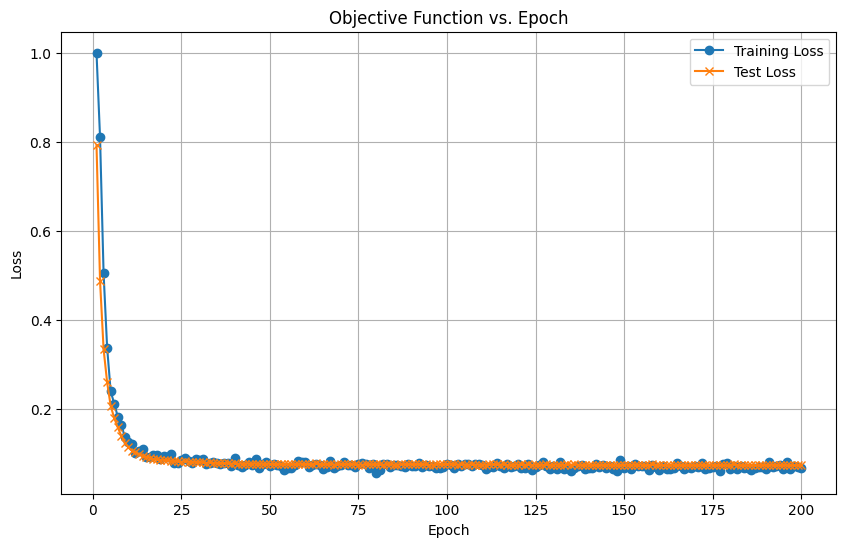

In [20]:
epochs = range(1, len(train_loss) + 1)  # Epochs are 1-based indexing

plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.title('Objective Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
os.getcwd()

'/Users/jeqcho/astro-205/grb'

In [22]:
nr = True
dft = False

fname = "final_dft_Autoencoder_"
if nr:
    fname += "Noise_Reduced_"
fname += f"{swift.res}res_"
fname += f'{"".join(str(b) for b in swift.n_bands)}bands_'
if dft:
    fname += f'DFT_'
# notes
fname += f'final-3-latent'


torch.save(AE.state_dict(), f'{fname}state_dict.pth')
# torch.save(AE, f'{fname}.pth')
print(f"Model saved to  f'{fname}state_dict.pth")

Model saved to  f'final_dft_Autoencoder_Noise_Reduced_64res_12345bands_final-3-latentstate_dict.pth


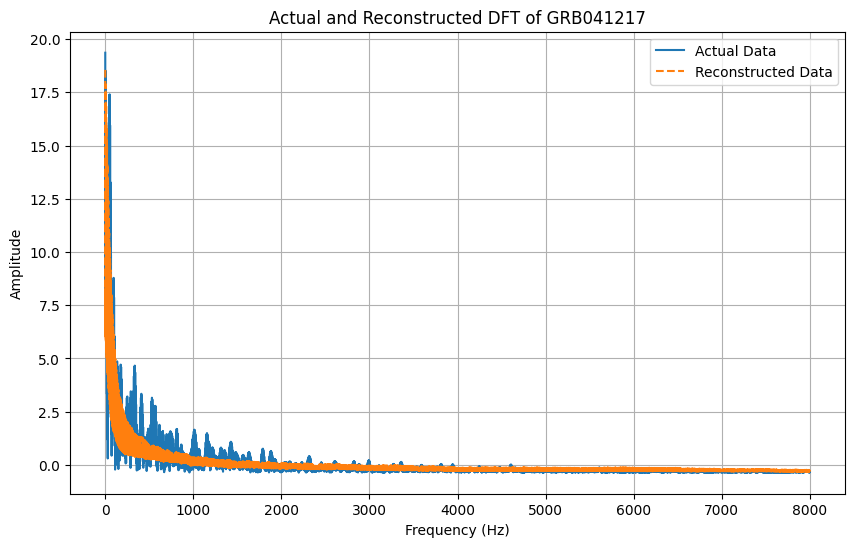

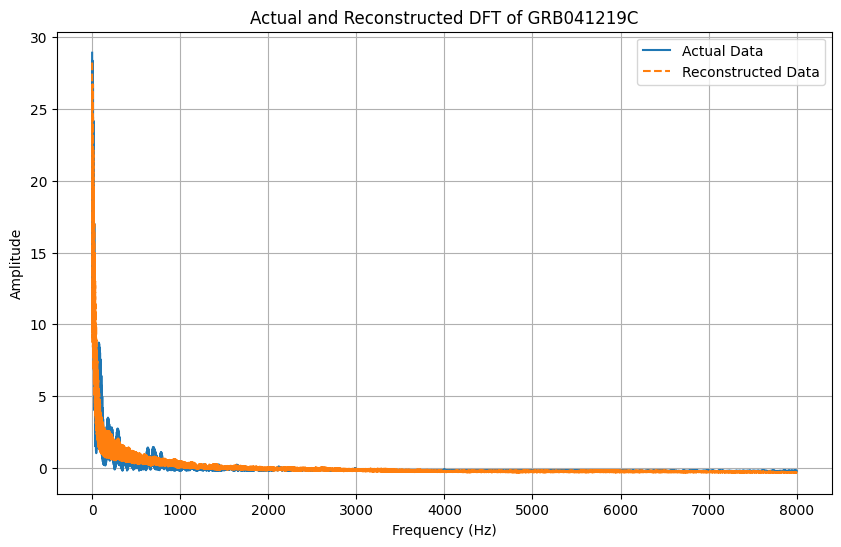

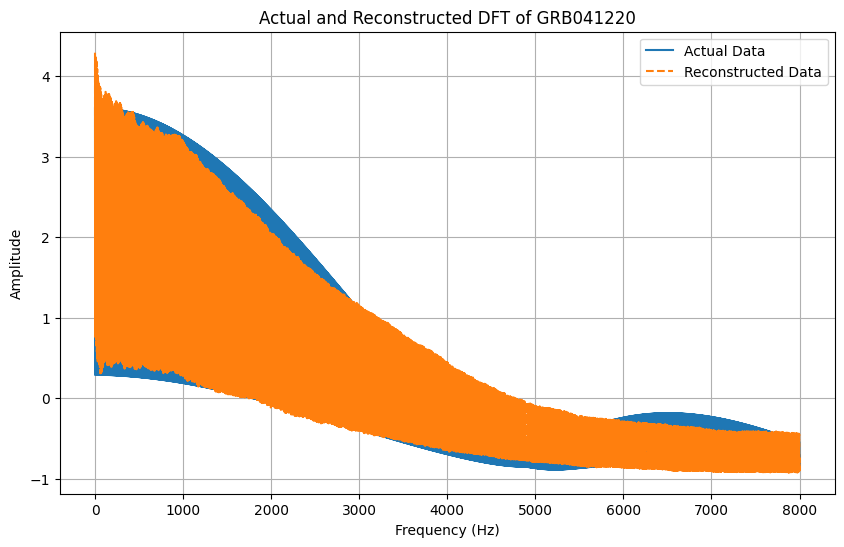

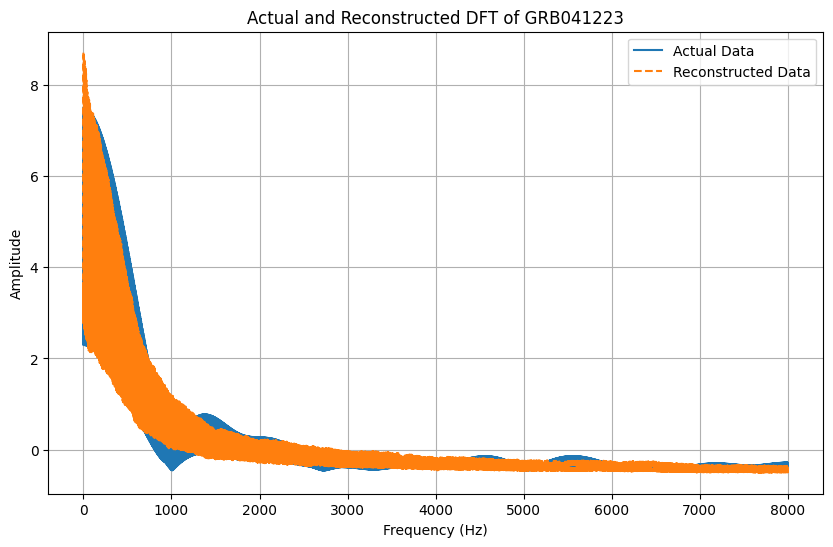

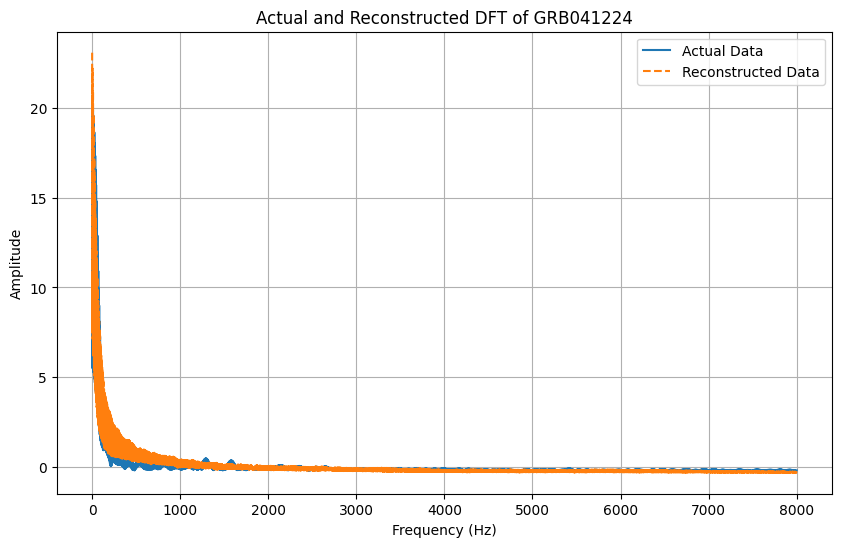

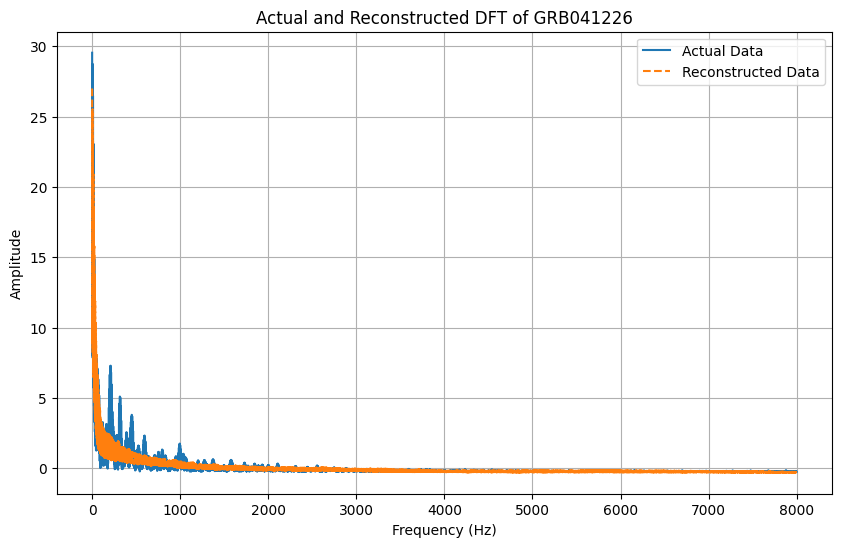

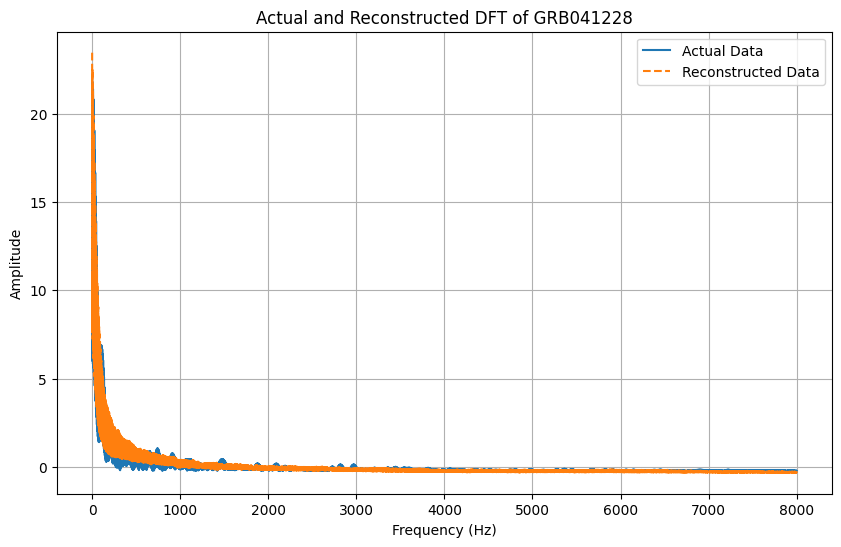

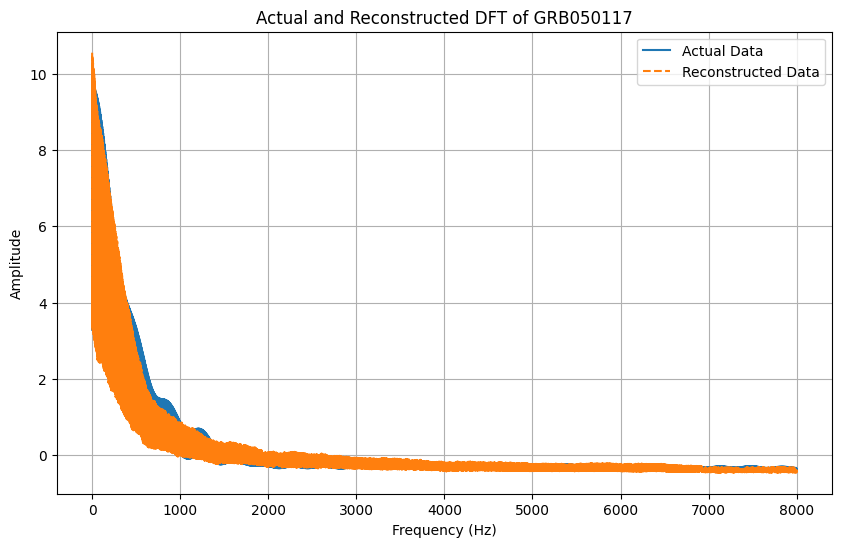

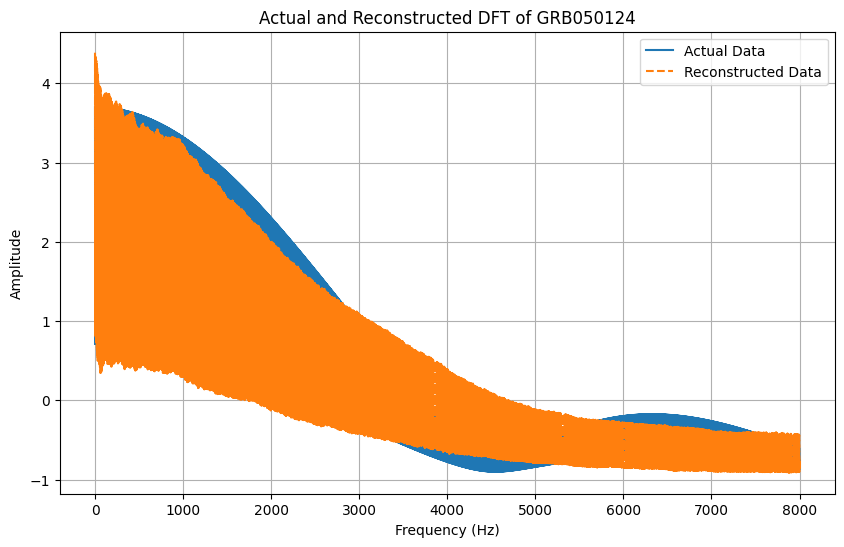

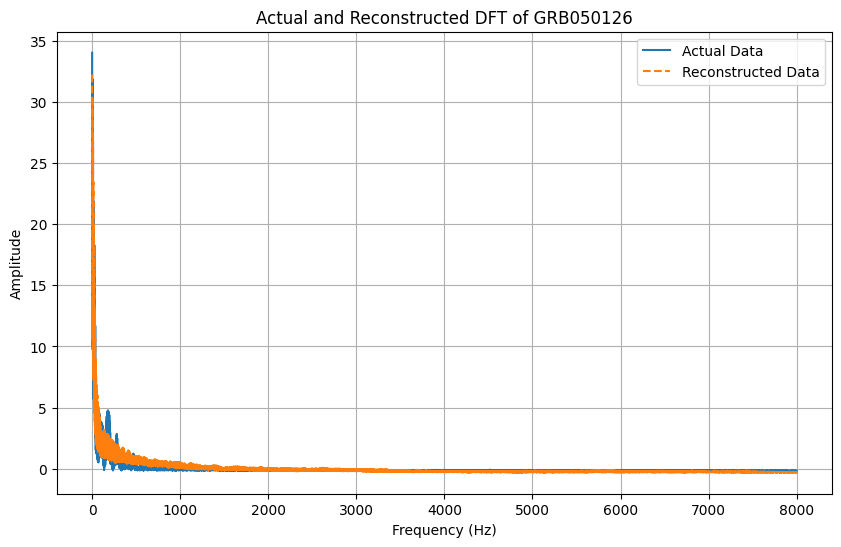

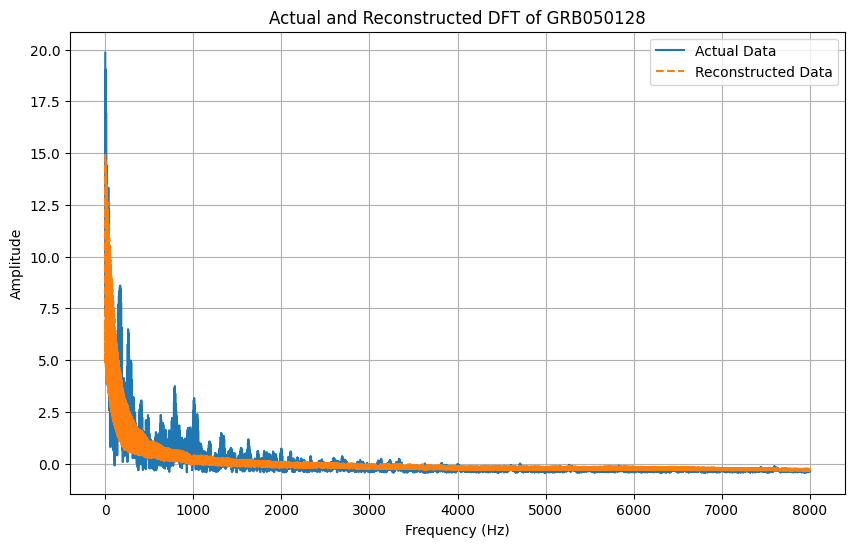

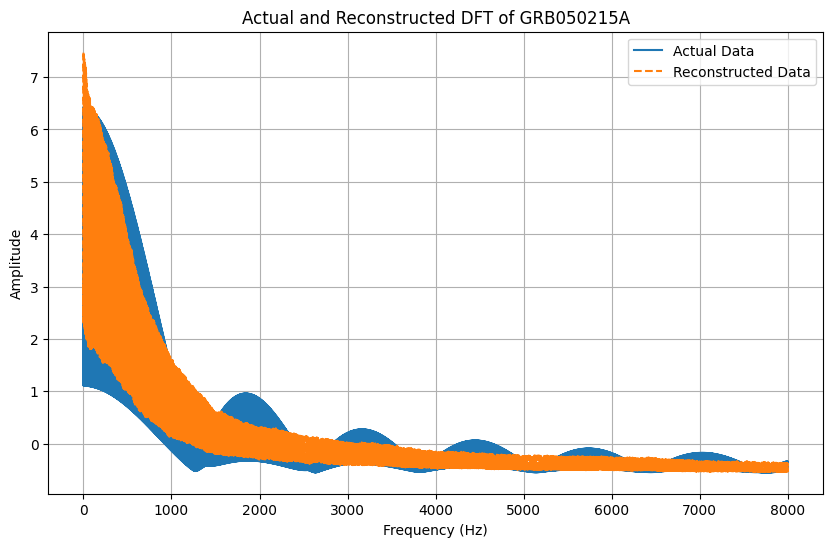

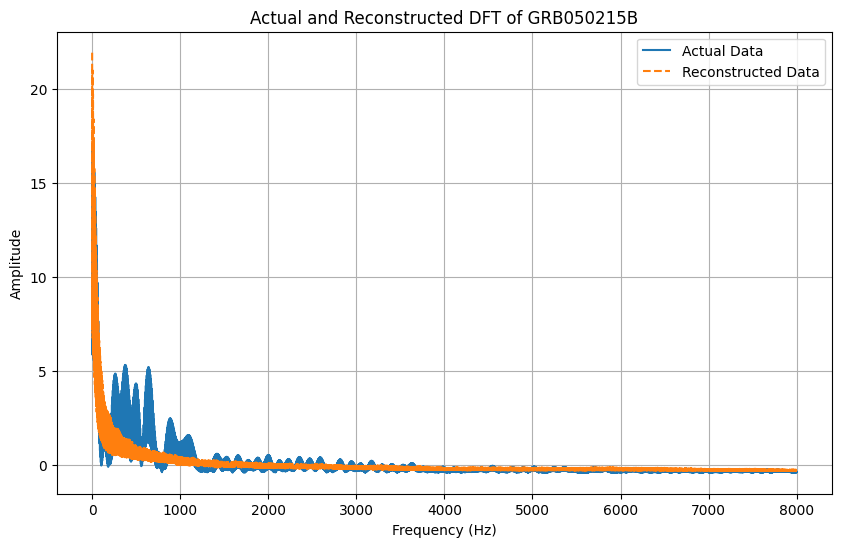

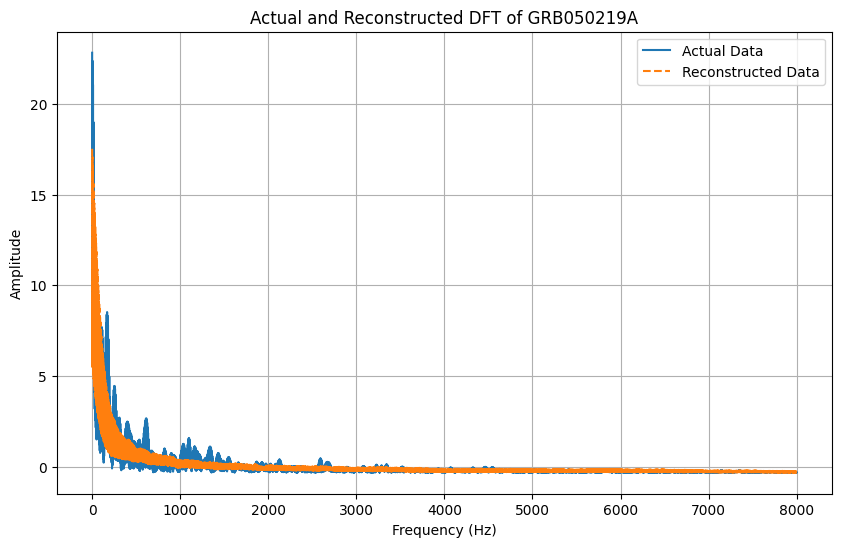

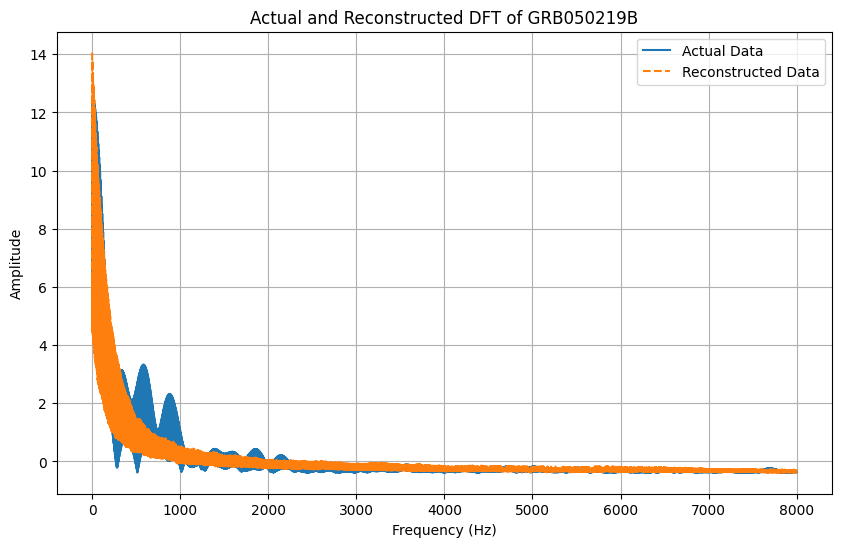

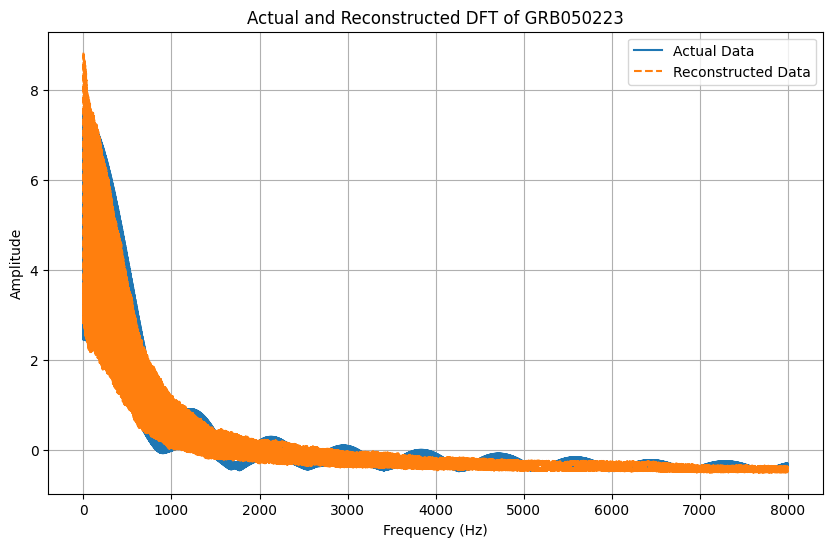

In [23]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Data')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Data',linestyle='--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f'Actual and Reconstructed DFT of {grb_names[i]}')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

In [24]:
preds2 = []
for x in normalized_features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[ 87.6965, -16.2673],
        [ 87.7008, -31.6455],
        [ 85.2368,  -7.9307],
        ...,
        [ 85.4442, -20.0977],
        [ 77.0088, -43.1790],
        [ 82.4501, -45.9051]])

In [25]:
mask = ~torch.isnan(preds2).any(dim=1)
preds2 = preds2[mask]
torch.sum(~mask)

tensor(0)

In [26]:
# Get all permutations of three columns out of five (0-based indices)
from itertools import combinations

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 T_90')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


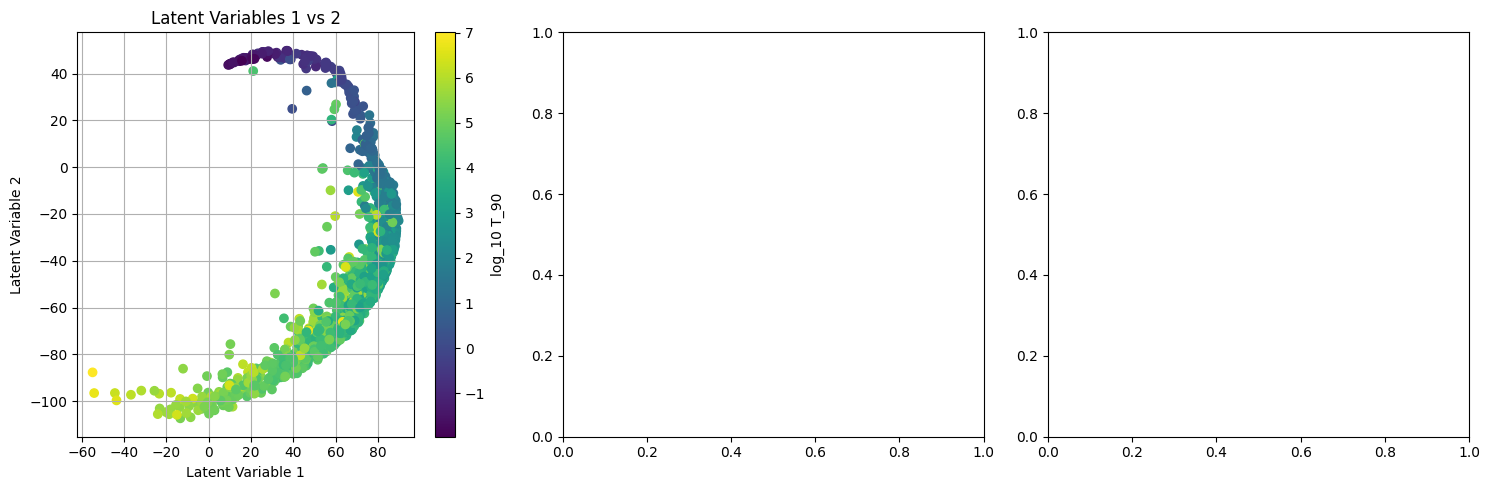

In [27]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
nrows = 1
ncols = 3
figsize = (15,5)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=np.log(durations[mask]), cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [54]:
len(durations) == len(preds2)

True

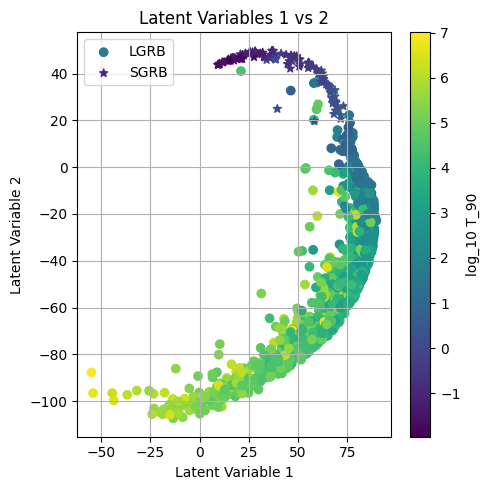

In [84]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))
highlight_duration = durations[mask] < 2
mask_not_in_highlight = ~highlight_duration
color_min = np.log(durations).min()
color_max = np.log(durations).max()
# Create plots for all combinations
nrows = 1
ncols = 1
figsize = (5,5)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    elif ncols>1:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs
    scatter = ax.scatter(preds2[mask_not_in_highlight, idx1].numpy(), preds2[mask_not_in_highlight, idx2].numpy(),
                         c=np.log(durations[mask_not_in_highlight]), cmap='viridis', vmin=color_min, vmax=color_max,label="LGRB")
    scatter = ax.scatter(preds2[highlight_duration, idx1].numpy(), preds2[highlight_duration, idx2].numpy(), 
                         c=np.log(durations[highlight_duration]), cmap='viridis', marker='*', vmin=color_min, vmax=color_max,label="SGRB")
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.legend()
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

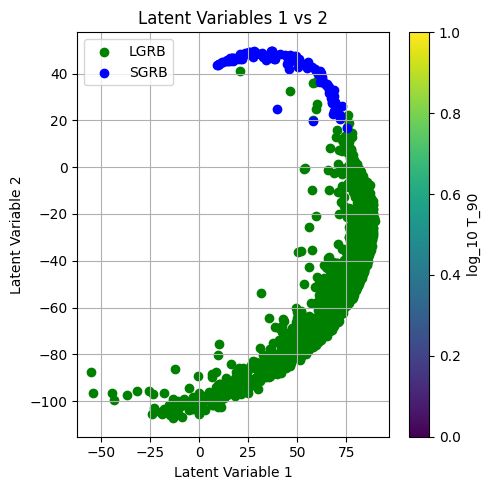

In [83]:
# Generate all combinations of the 5 coordinates taken 2 at a time
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    elif ncols>1:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs
    scatter = ax.scatter(preds2[mask_not_in_highlight, idx1].numpy(), preds2[mask_not_in_highlight, idx2].numpy(),
                         c='green',label="LGRB")
    scatter = ax.scatter(preds2[highlight_duration, idx1].numpy(), preds2[highlight_duration, idx2].numpy(), 
                         c='blue',label="SGRB")
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)
    ax.legend()

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [28]:
compact_mergers = [
    "GRB130603B",
    "GRB060614",
    "GRB080503",
    "GRB050709",
    "GRB050724",
    "GRB061006",
    "GRB070714B",
    "GRB160821B",
    "GRB111005A",
    "GRB150101B",
    "GRB070809",
    "GRB211211A",
    "GRB211227A",
    "GRB191019A",
    "GRB230307A"
]
indices = np.where(np.isin(grb_names, compact_mergers))[0]
mask_not_in_indices = ~np.isin(range(len(preds2)), indices)
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

In [29]:
from sklearn.cluster import KMeans

encoded2 = preds2
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(encoded2)
kmeans2

KMeans(n_clusters=2, random_state=205)

In [30]:
# Get all permutations of three columns out of five (0-based indices)

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], 
                                     c='r')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

IndexError: index 2 is out of bounds for dimension 1 with size 2

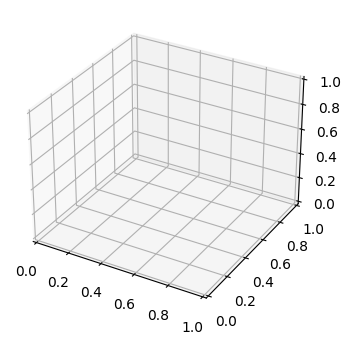

In [31]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 T_90')  # Add a colorbar with label
plt.tight_layout()
plt.show()

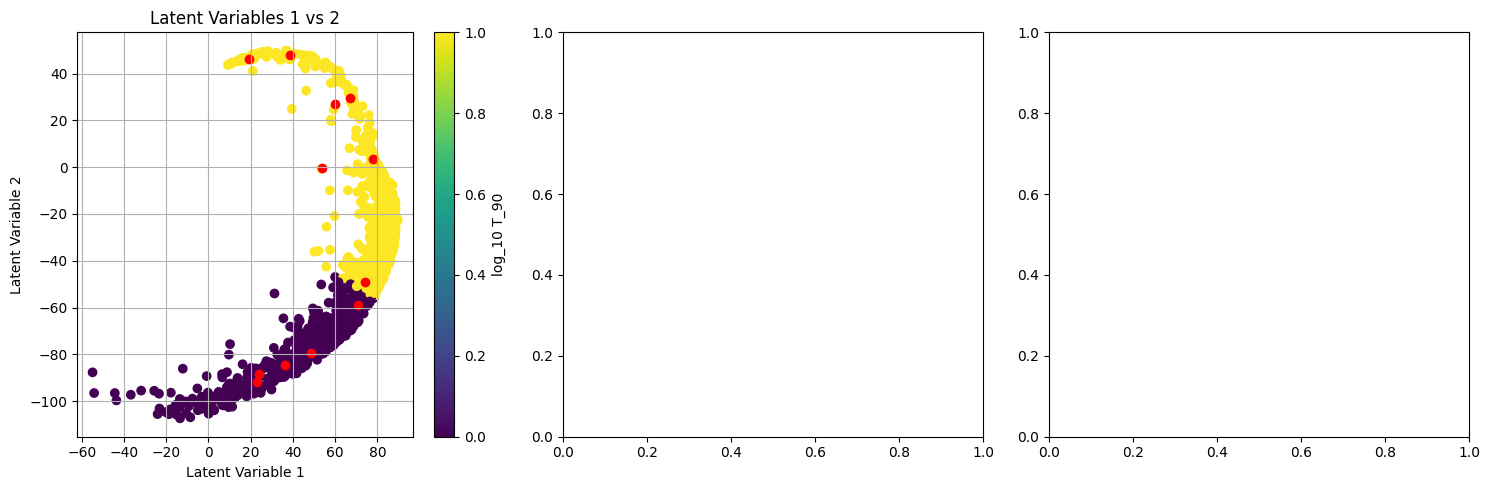

In [32]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), 
                         c=kmeans2.labels_[mask_not_in_indices], cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [33]:
encoded = preds2

In [34]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

In [35]:
names_64ms = names_64ms[mask]

In [36]:
# Values
values = np.array([0, 1])

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.993248 0.906157 0.143936 1.      ]


In [37]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

Finding Durations: 100%|████████████████████| 676/676 [00:05<00:00, 129.02GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=2')

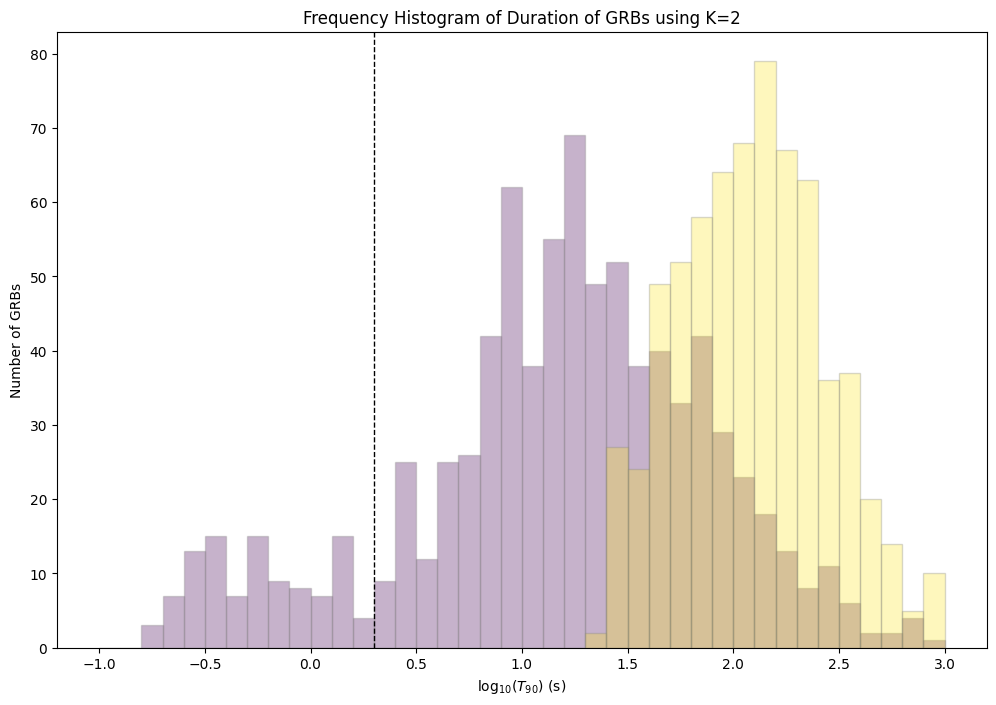

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=2')

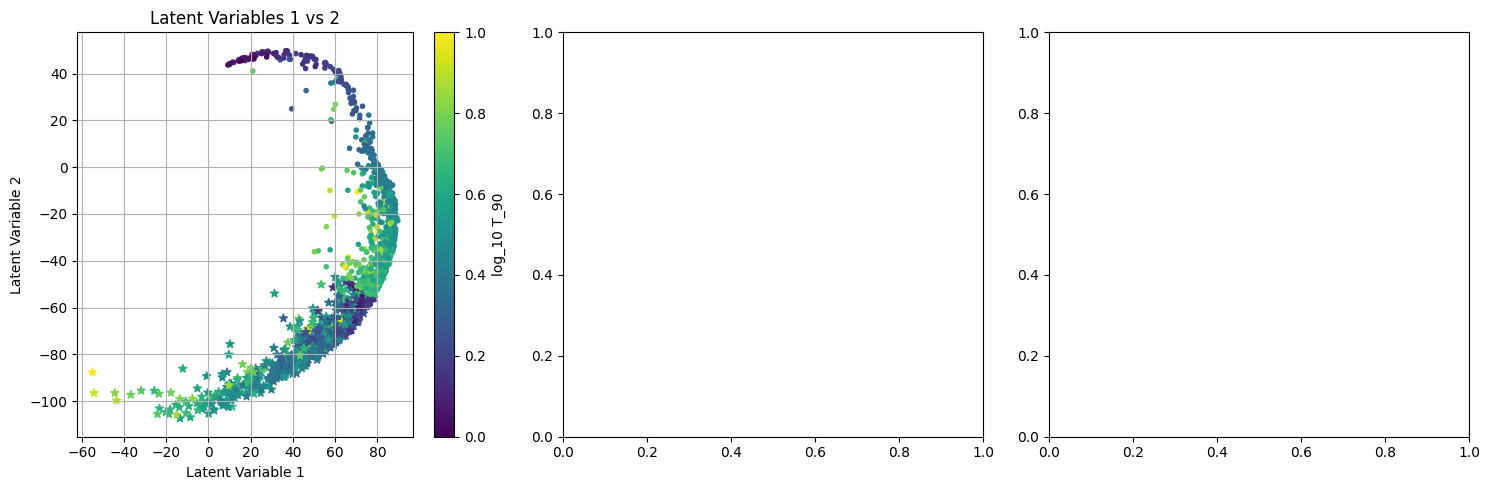

In [39]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

labls = kmeans2.labels_
centers = kmeans2.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2']

markers = ['*', '.']
edgecolors = ['red', 'black']

fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [40]:
import numpy as np


# Exploring the array
print("Shape of the array:", durations[mask].shape)
print("Data type of the array:", durations[mask].dtype)
print("Number of dimensions:", durations[mask].ndim)
print("Total number of elements:", durations[mask].size)

# Describing the durations[mask]
print("Mean of the array:", np.mean(durations[mask]))
print("Standard deviation:", np.std(durations[mask]))
print("Minimum value:", np.min(durations[mask]))
print("Maximum value:", np.max(durations[mask]))
print("25th percentile:", np.percentile(durations[mask], 25))
print("Median:", np.median(durations[mask]))
print("75th percentile:", np.percentile(durations[mask], 75))
print("90th percentile:", np.percentile(durations[mask], 90))
print("95th percentile:", np.percentile(durations[mask], 95))
print("99th percentile:", np.percentile(durations[mask], 99))

Shape of the array: (1513,)
Data type of the array: float64
Number of dimensions: 1
Total number of elements: 1513
Mean of the array: 76.21325842696629
Standard deviation: 107.63104972105164
Minimum value: 0.14
Maximum value: 1104.7520000000002
25th percentile: 11.904
Median: 41.0
75th percentile: 97.69999999999999
90th percentile: 181.992
95th percentile: 270.82320000000004
99th percentile: 545.7420799999968


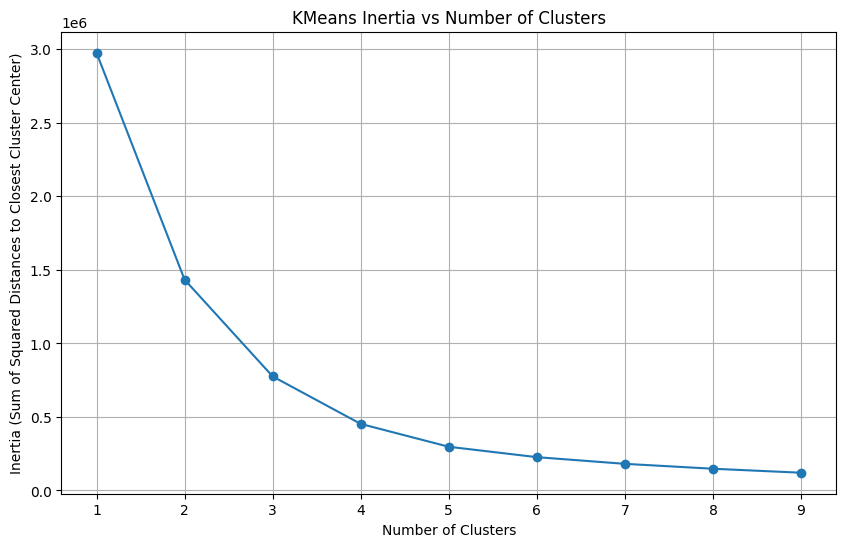

In [41]:
# Try different numbers of clusters
num_clusters = range(1, 10)  # You can adjust the range as needed
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=205)
    kmeans.fit(encoded2)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances to Closest Cluster Center)')
plt.grid(True)
plt.show()

In [42]:
kmeans3 = KMeans(n_clusters=3, random_state=205).fit(encoded2)

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans3.labels_, cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

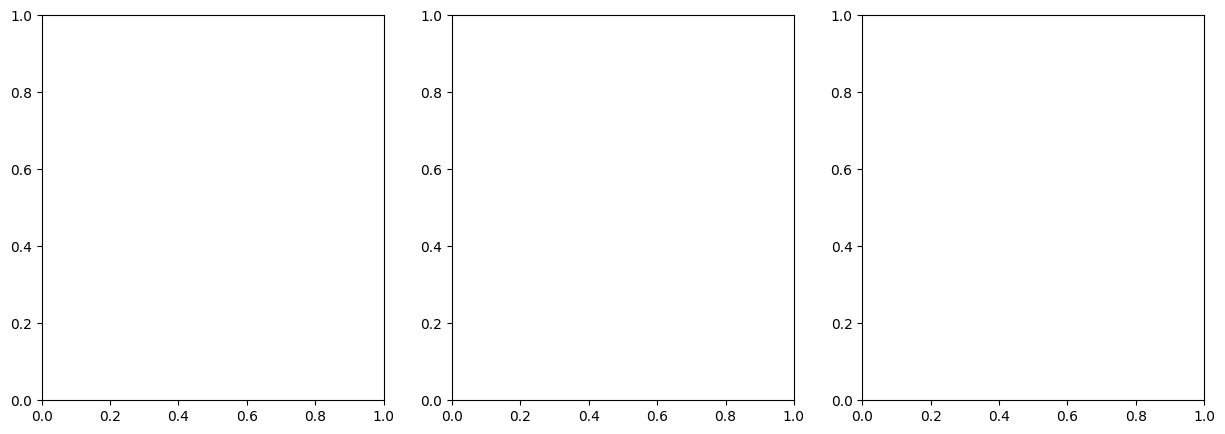

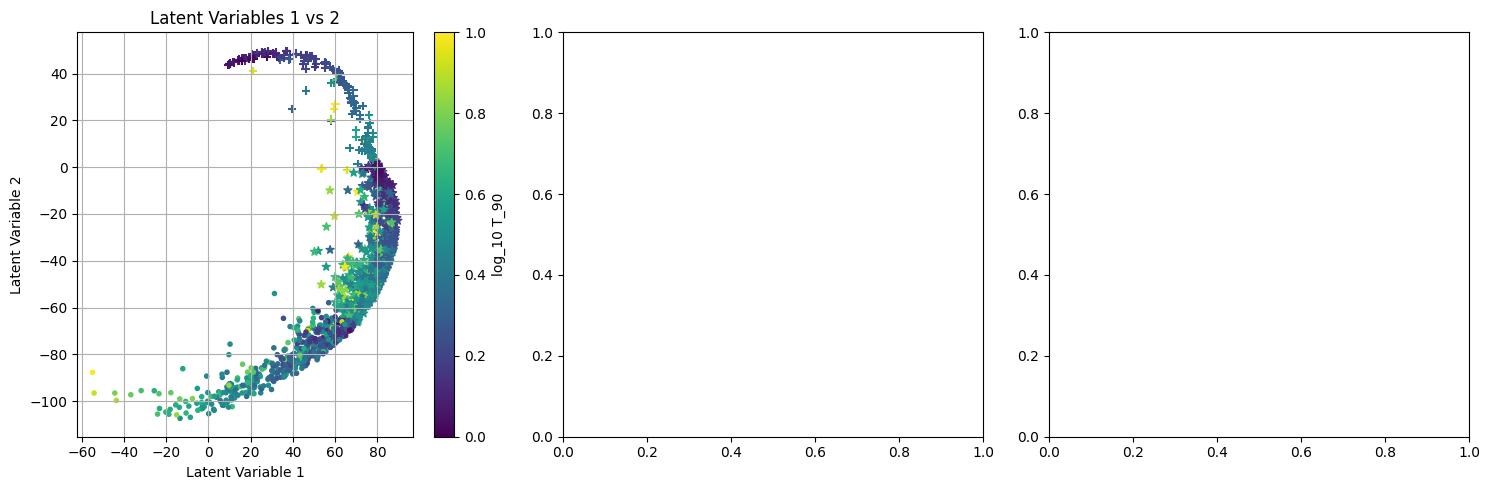

In [43]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

labls = kmeans3.labels_
centers = kmeans3.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2','g3']

markers = ['*', '.','+']
edgecolors = ['red', 'black']


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

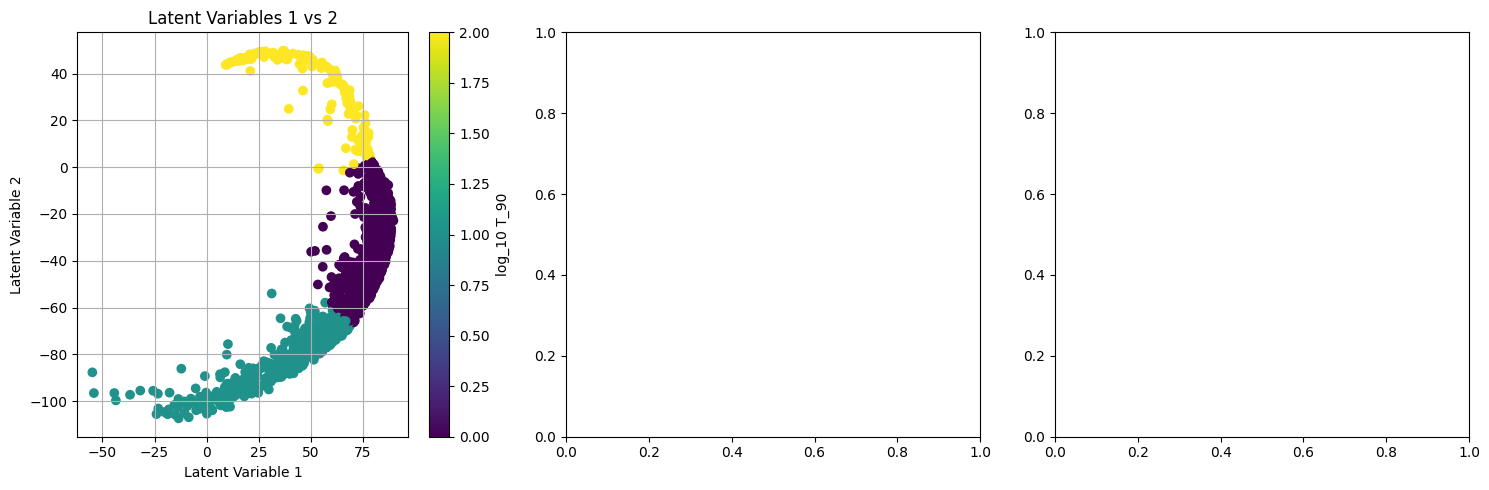

In [44]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans3.labels_, cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [45]:
# Values
values = np.arange(3)

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.127568 0.566949 0.550556 1.      ]
Value 2 has color: [0.993248 0.906157 0.143936 1.      ]


Finding Durations: 100%|█████████████████████| 164/164 [00:06<00:00, 25.75GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=3')

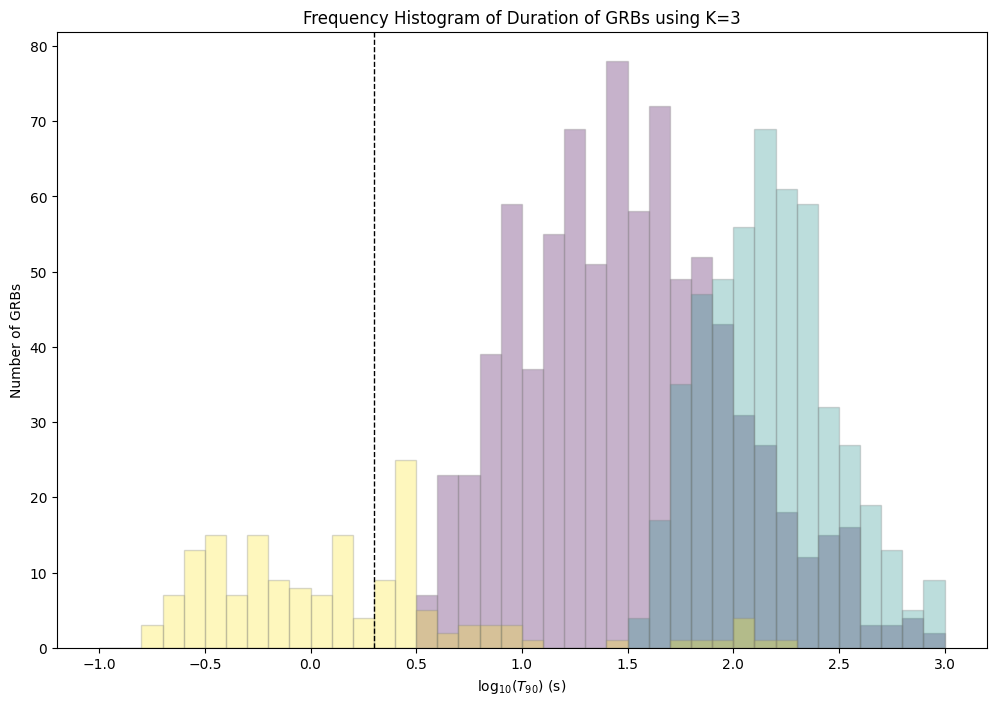

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match1 = kmeans3.labels_==0
match2 = kmeans3.labels_==1
match3 = kmeans3.labels_==2
names1 = names_64ms[match1]
names2 = names_64ms[match2]
names3 = names_64ms[match3]
swift.duration_histogram(names=[names1, names2, names3], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=3')

In [47]:
torch.sum(~mask)

tensor(0)

In [48]:
# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    _indices = np.where(names_64ms == merger)[0]
    results[merger] = _indices[0] if _indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans2.labels_[value]}")

GRB130603B: 1
GRB060614: 0
GRB080503: 0
GRB050709: 1
GRB050724: 1
GRB061006: 1
GRB070714B: 1
GRB160821B: 1
GRB111005A: 0
GRB150101B: 1
GRB070809: 1
GRB211211A: 1
GRB211227A: 0
GRB191019A: 0
GRB230307A: 1


In [49]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 T_90')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


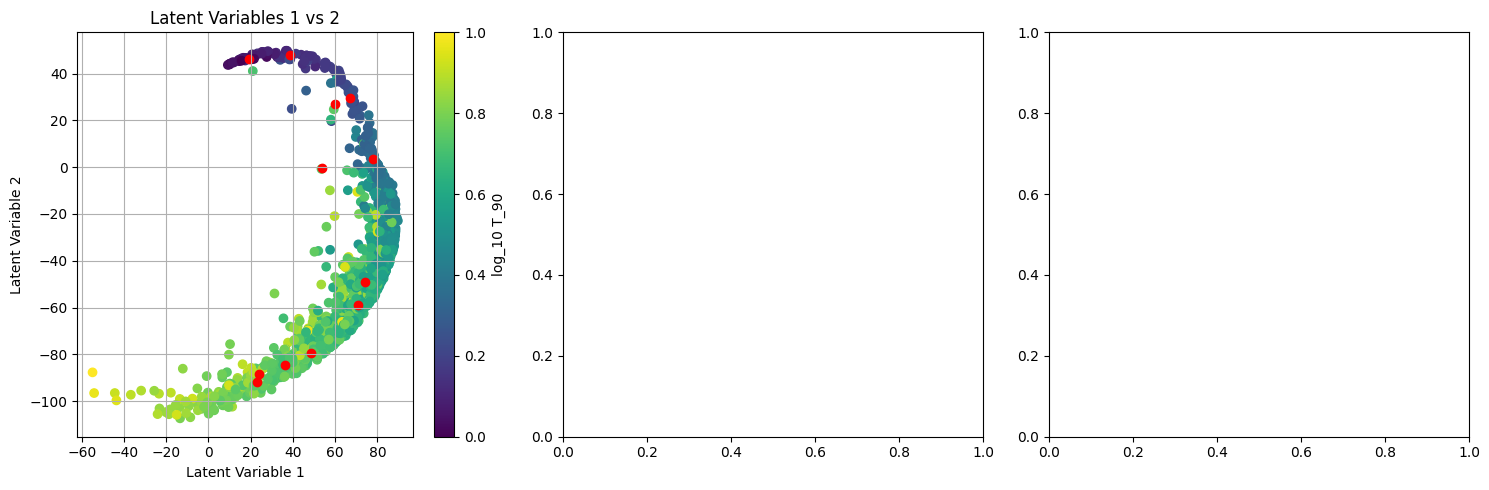

In [50]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), c=np.log(durations[mask_not_in_indices]), cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [51]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 T_90')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


IndexError: index 2 is out of bounds for dimension 1 with size 2

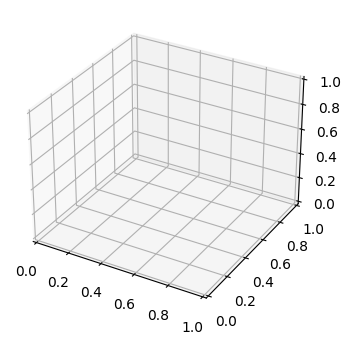

In [52]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 T_90')  # Add a colorbar with label
plt.tight_layout()
plt.show()

In [ ]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [1,2,3]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 T_90')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')


In [ ]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [0,1,2]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 T_90')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')
